# Pancreas Advanced

This tutorial shows how to apply CellRank to data to infer start/end-points of a developmental process and also how to compute a probabilistic lineage assignment for each cell. The first part of this tutorial is copied from [scVelo's tutorial on pancreatic endocrinogenesis](https://scvelo-notebooks.readthedocs.io/Pancreas.html). The data we use here comes from [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract). 

For more info on scVelo, see the [github](https://scvelo-notebooks.readthedocs.io/index.html) or read the [preprint](https://www.biorxiv.org/content/10.1101/820936v1). 

This is the 'advanced' or low level mode to interact with cellrank, which is not as scary as it sounds. It just means you will interact directly with our two main classes, `KernelExpression` and `Markov_Chain`. We assume here that you went over our `pancreas_basic` tutorial already. 

This tutorial will reproduce the results from the `pancreas_basic` tutorial using the low level interface. 

## Import packages & data

We start by importing all required packages and data. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import matplotlib.cm as cm

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [3]:
adata = scv.datasets.pancreatic_endocrinogenesis()
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.83 0.17]


AnnData object with n_obs × n_vars = 3696 × 27998 
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

## Pre-processing

Pre-process the data and compute moments.

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


## Run scVelo

We will use the dynamical model from scVelo to estimate the velocities, this may take a while (~10min) to compute. Consider caching this computation using [scachepy](https://github.com/theislab/scachepy). The first step is to estimate the parameters of the dynamical model.

In [5]:
import scachepy 
c = scachepy.Cache('../../../cellrank_notebooks_dev/notebooks/cache/pancreas/', backend='pickle', separate_dirs=True)
c.tl.recover_dynamics(adata, fname='recover_dynamics_day15.5_original_volker', force=False)

#scv.tl.recover_dynamics(adata)

Loading data from: `recover_dynamics_day15.5_original_volker.pickle`.


Once we have the parameters, we can use these to compute the velocities and the velocity graph. The velocity graph is a weighted graph that specifies how likely two cells are to transition into another, given their velocity vectors and relative positions. 

In [6]:
scv.tl.velocity(adata, mode='dynamical', min_r2=None)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


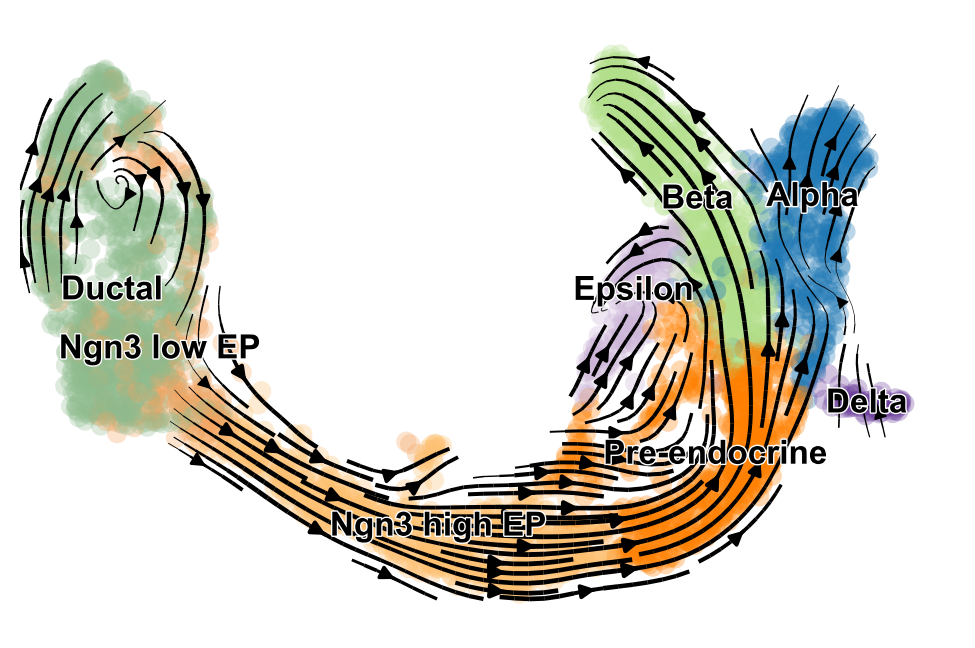

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)

## CellRank

Recompute the velocity graph, using `mode_neighbors='connectivities'` to ensure the the resulting KNN graph is symmetric and `n_recurse_neighbors=0` to ensure that we only consider actual (first order) neighbors. 

In [8]:
scv.tl.velocity_graph(adata, mode_neighbors='connectivities', n_recurse_neighbors=0)

computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Final Cells

To construct a transition matrix, CellRank offers a number of kernel classes in `cellrank.tools.kernels`. Currently implemented are a `VelocityKernel` which reproduces the results from the high-level mode, a `ConnectivityKernel` which computes symmetric transition probabilities based on transcriptomic similarity (essentially a [DPT](https://doi.org/10.1038/nmeth.3971) kernel) and a `PalantirKernel`, which mimics [Palantir](https://doi.org/10.1038/s41587-019-0068-4). To find out more, check out the API. 

In [9]:
from cellrank.tools.kernels import VelocityKernel
vk = VelocityKernel(adata).compute_transition_matrix()

Computing transition matrix based on velocity correlations
    Finish` (0:00:00)


To see how exactly this transition matrix was computed, we can print the kernel:

In [10]:
print(vk)

<Velo[dnorm=True, bwd_mode=None, sigma_corr=11.17]>


This tells us whether we applied a density correction, whether this it the forward or backward process and what the scaling factor is that we used in the softmax function. We use a softmax function to get from cosine correlations to probabilities. Based on this kernel object, we can initialise a Markov Chain object:

In [11]:
mc_fwd = cr.tl.MarkovChain(vk)
print(mc_fwd)

MarkovChain[n=3696, kernel=<Velo[dnorm=True, bwd_mode=None, sigma_corr=11.17]>]


The first step to compute the endpoints is to compute an eigendecomposition of the underlying transition matrix. Note that since the matrix is not symmetric, there will be different left and right eigenvectors, and these will in general be complex. Eigenvalues for left and right eigenvectors are shared. 

Computing eigendecomposition of transition matrix


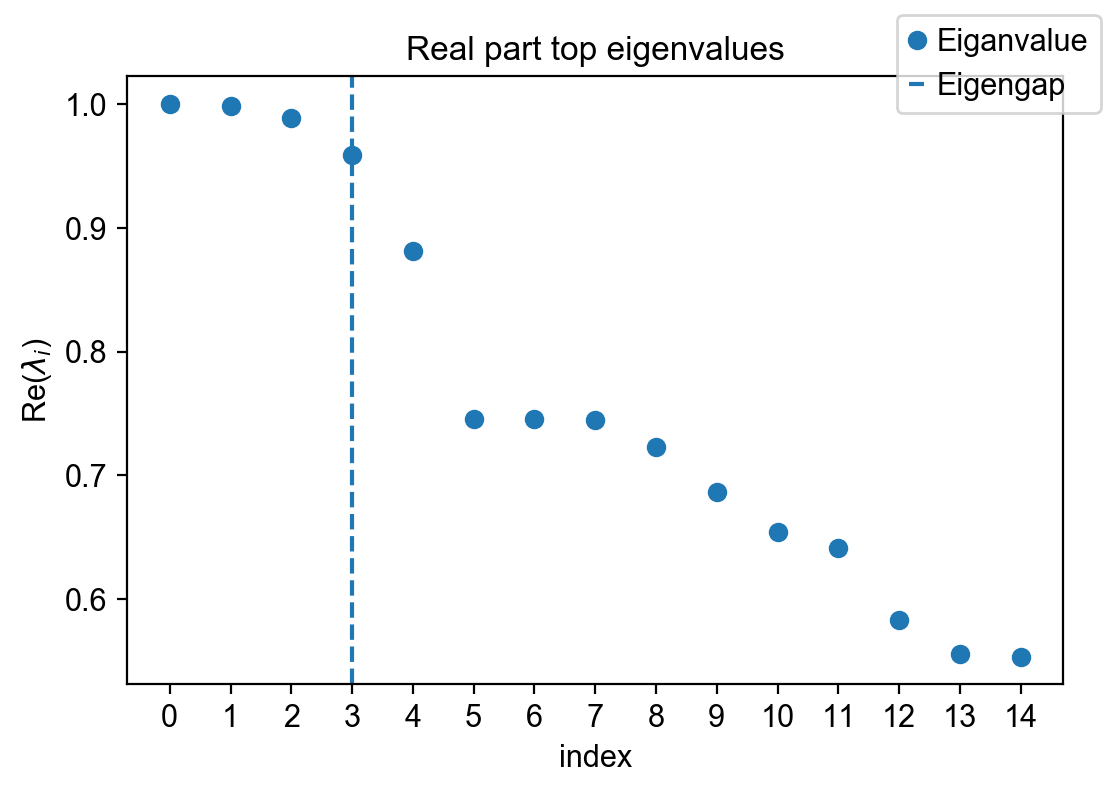

In [12]:
mc_fwd.compute_eig()
mc_fwd.plot_real_spectrum()

Above, we plotted the real part of the first couple of eigenvalues (with largest real part). From spectral clustering, we know that (right) eigenvectors before the eigengap are related to the indicator vectors of a related disconnected graph. A similar heuristic is applied here. We assume that left eigenvectors before the eigengap are informative of transient vs. recurrent cell states and the corresponding right eigenvectors before the eigengap are informative of the grouping of (both recurrent and transient) cell states. But where is the eigengap? In the current case, it could be either after 4 or 5 eigenvalues. To find out, we plot the left & right eigenvectors in the embedding:

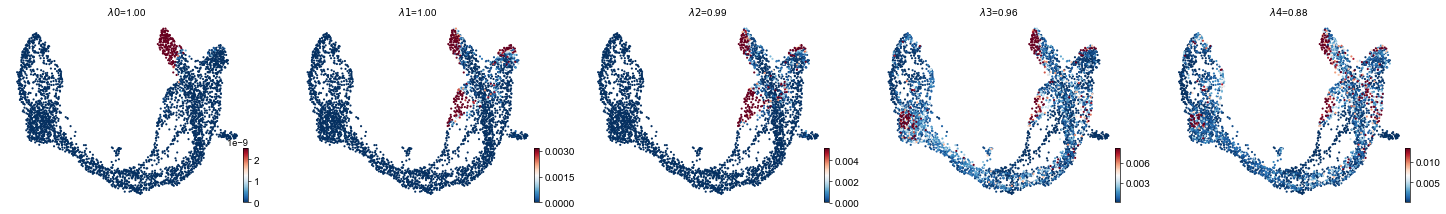

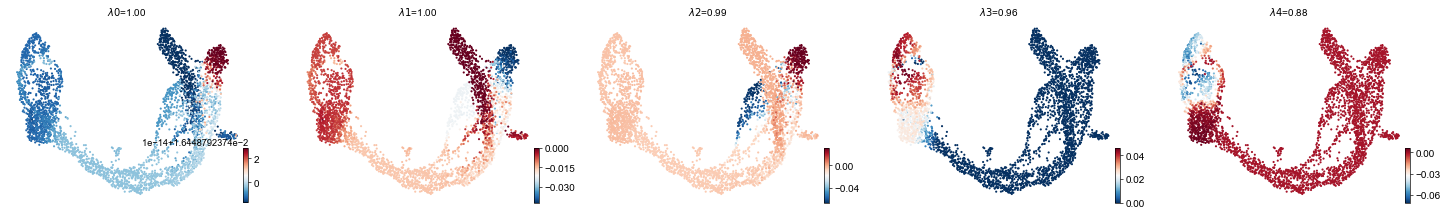

In [25]:
use = 5
mc_fwd.plot_eig_embedding(abs_value=True, perc=[0, 95], use=use, dpi=30)
mc_fwd.plot_eig_embedding(left=False, use=use, dpi=30)

The top row are the left eigenvectors - these should tell us where recurrent (in this case, final) cell's are. The 5th vector does not seem to add much - it mostly contains the same cells as the 4 others, plus some scattered cells. To really find out whether this vector should be taken into account or not, one has to look at the extra cells that this 5th vector marks and asses their transcriptional profile. 

Once we have decided how many eigenvectors to use, we can filter cells in the left eigenvector and cluster in the right:

Computing approximate recurrent classes
Adding `adata.uns['final_cells_colors']`
       `adata.obs['final_cells_probs']`
       `adata.obs['final_cells']`
       `.approx_rcs_colors`
       `.approx_rcs_probs`
       `.approx_rcs`
    Finish (0:00:00)


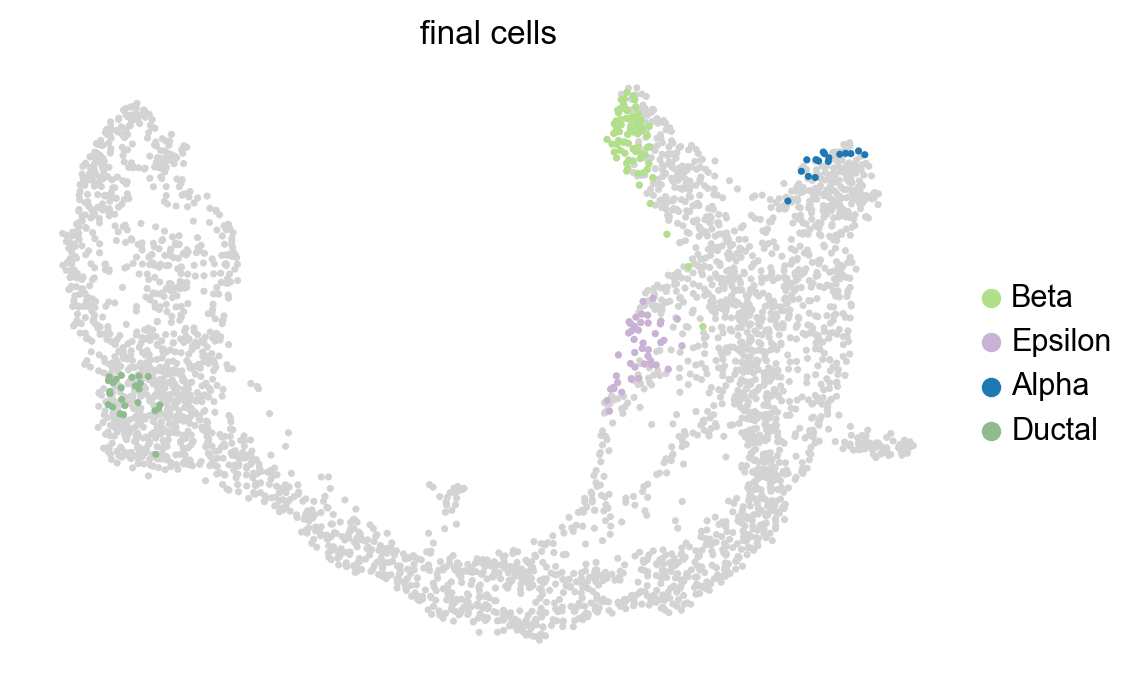

In [14]:
mc_fwd.compute_approx_rcs(cluster_key='clusters', n_matches_min=1)
scv.pl.scatter(adata, color='final_cells', legend_loc='right margin')

By not specifying a number of eigenvectors via the `use=` parameter, we use the suggested number (dashed line in `mc_fwd.plot_real_spectrum()`). This is computed via a heuristic that tries to find the *first significant drop*.  

The `n_matches_min` argument can be used to filter outliers. By specifying `n_matches_min=L`, we check for each cell `i` whether at least `L` of it's neighbors have been assigned to the same endpoint. If not, the cell is not considered an endpoint. In the current case, using `L=1` filters out 2 outliers from the beta endpoint. 

## Lineage Probabilities

Once we know where the endpoint are, we can compute how likely each cell is to travel/develop towards each of these:

Computing absorption probabilities
    Finish (0:00:00)


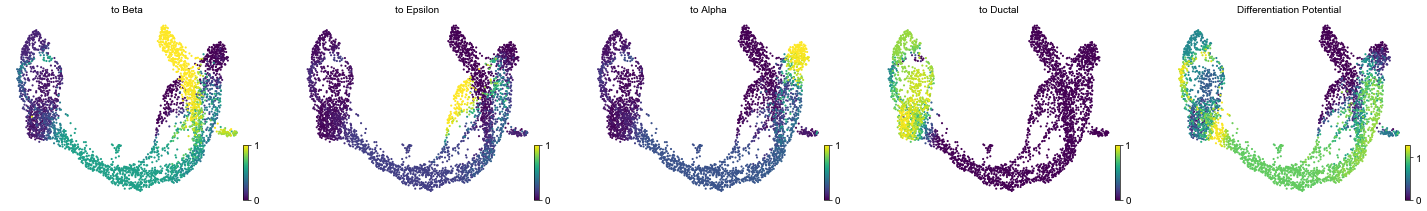

In [27]:
mc_fwd.compute_lin_probs()
mc_fwd.plot_lin_probs(dpi=30)

A handy feature is the ability to specify `keys` when calling the above function. Say we don't want to consider `Epsilon` as an endpoint, and we want to combine the `Alpha` and `Beta` probabilities. Then we simply call:

Computing absorption probabilities
    Finish (0:00:01)


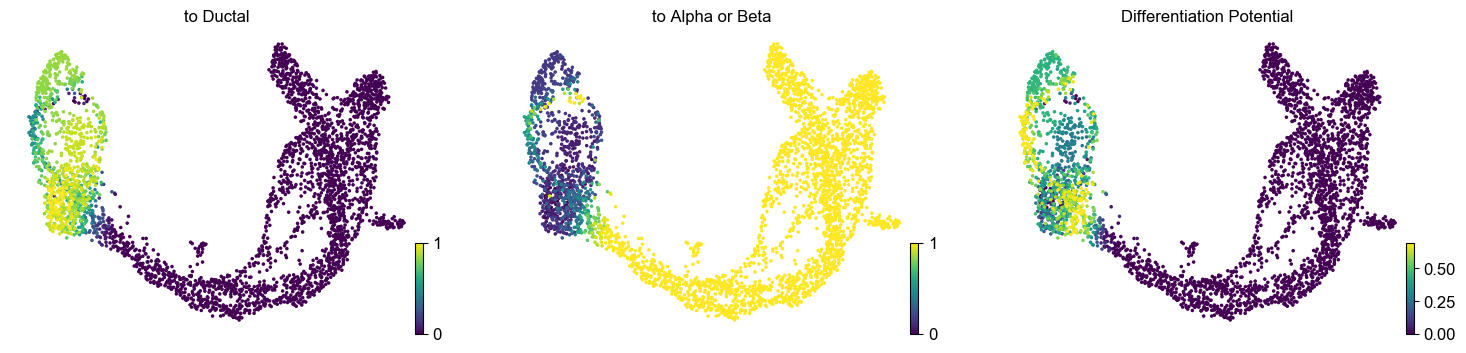

In [31]:
mc_fwd.compute_lin_probs(keys=['Ductal', 'Alpha, Beta'])
mc_fwd.plot_lin_probs(dpi=50)

These probabilities can now be plotted e.g. in a PAGA pie chart, as we show in the `pancreas_basic` tutorial. To demonstrate another plotting function, let's plot these probabilities here using violoin plots. Before we do so, let's recompue lineage probabilities again, this time combining all endocrine endpoints, so we can visualise the binary decision of becoming Ductal vs. Endocrine:

In [28]:
mc_fwd.compute_lin_probs(keys=['Ductal', 'Alpha, Beta, Epsilon'])

Computing absorption probabilities
    Finish (0:00:00)


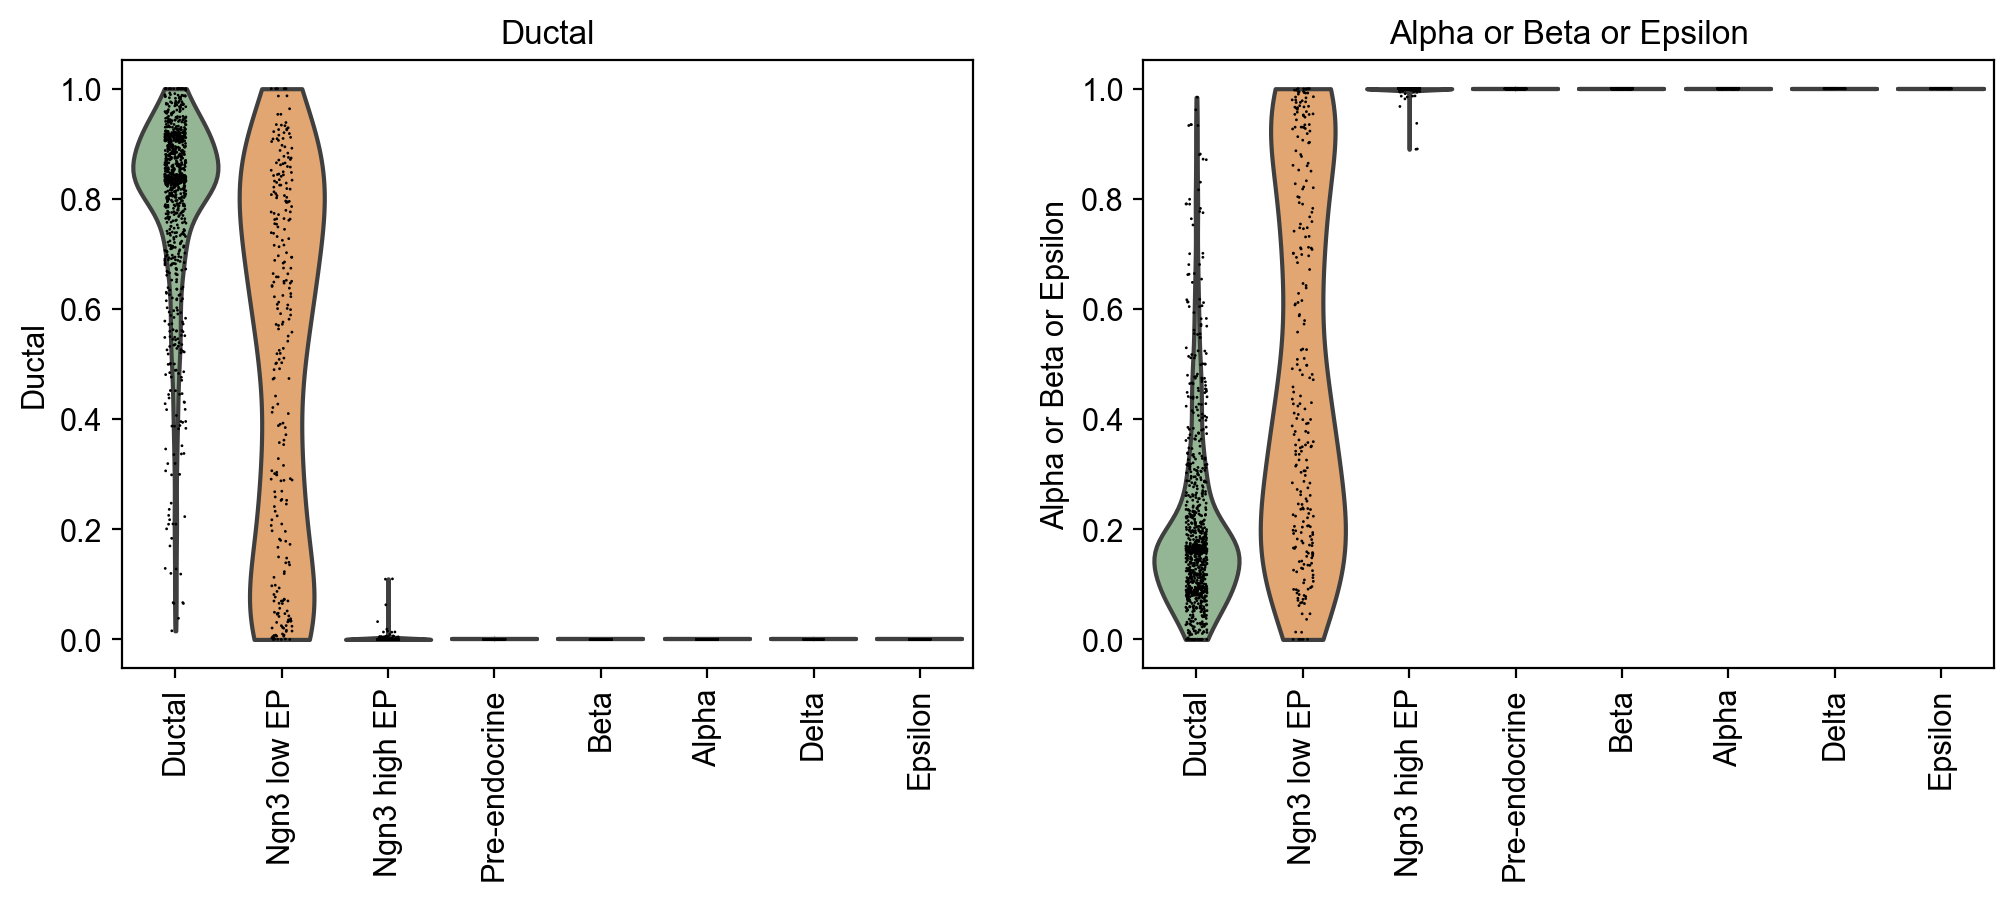

In [29]:
cr.pl.cluster_fates(adata, cluster_key='clusters', mode='violin')

## Root Cells

For root cells, we can again initialise a `VelocityKernel` object, only that this time, we specify `backward=True`. All other commands are the same as they were for the forwards case. 

In [20]:
vk_bwd = VelocityKernel(adata, backward=True).compute_transition_matrix()
mc_bwd = cr.tl.MarkovChain(vk_bwd)
print(mc_bwd)

Computing transition matrix based on velocity correlations
    Finish` (0:00:00)
MarkovChain[n=3696, kernel=<Velo[dnorm=True, bwd_mode=transpose, sigma_corr=11.17]>]


Computing eigendecomposition of transition matrix


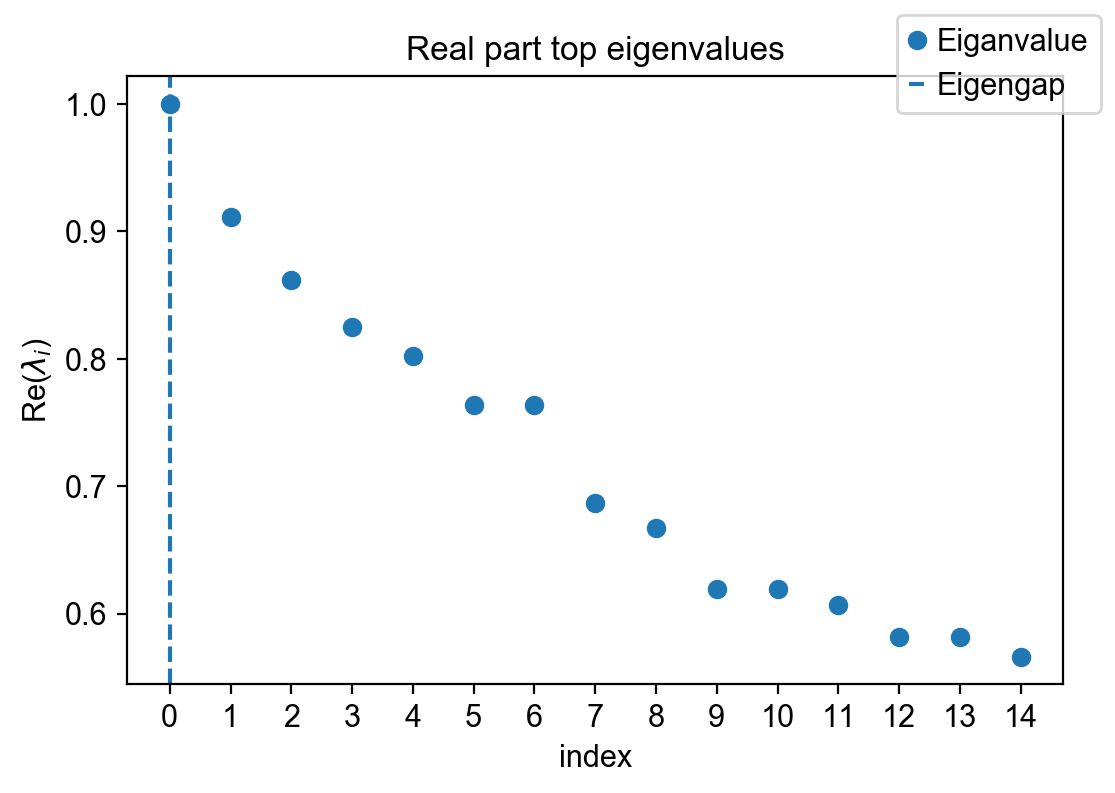

In [21]:
mc_bwd.compute_eig()
mc_bwd.plot_real_spectrum()

This time, the eigengap is quite obvious and we should only use the first eigenvalue. We can plot the corresponding left eigenvector:

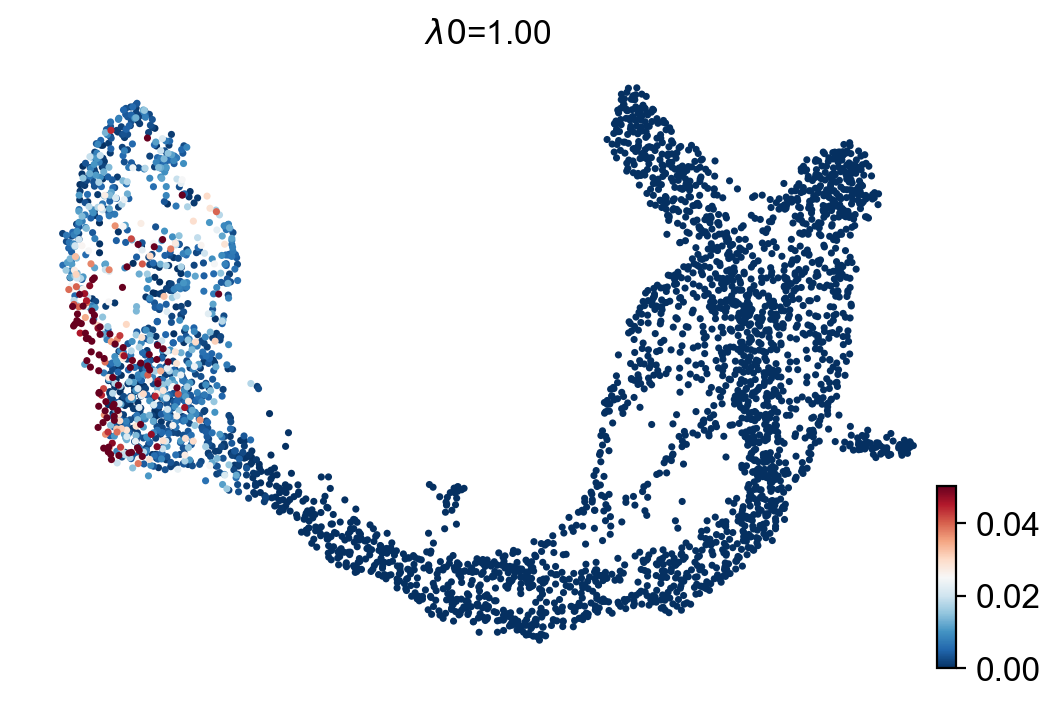

In [22]:
mc_bwd.plot_eig_embedding(abs_value=True, perc=[0, 98])

Since we are only considering one single eigenvector, we don't need to cluster. In this case, `.compute_approx_rcs` amounts to merely filtering cells based on the first left eigenvector:

Computing approximate recurrent classes
Adding `adata.uns['root_cells_colors']`
       `adata.obs['root_cells_probs']`
       `adata.obs['root_cells']`
       `.approx_rcs_colors`
       `.approx_rcs_probs`
       `.approx_rcs`
    Finish (0:00:00)


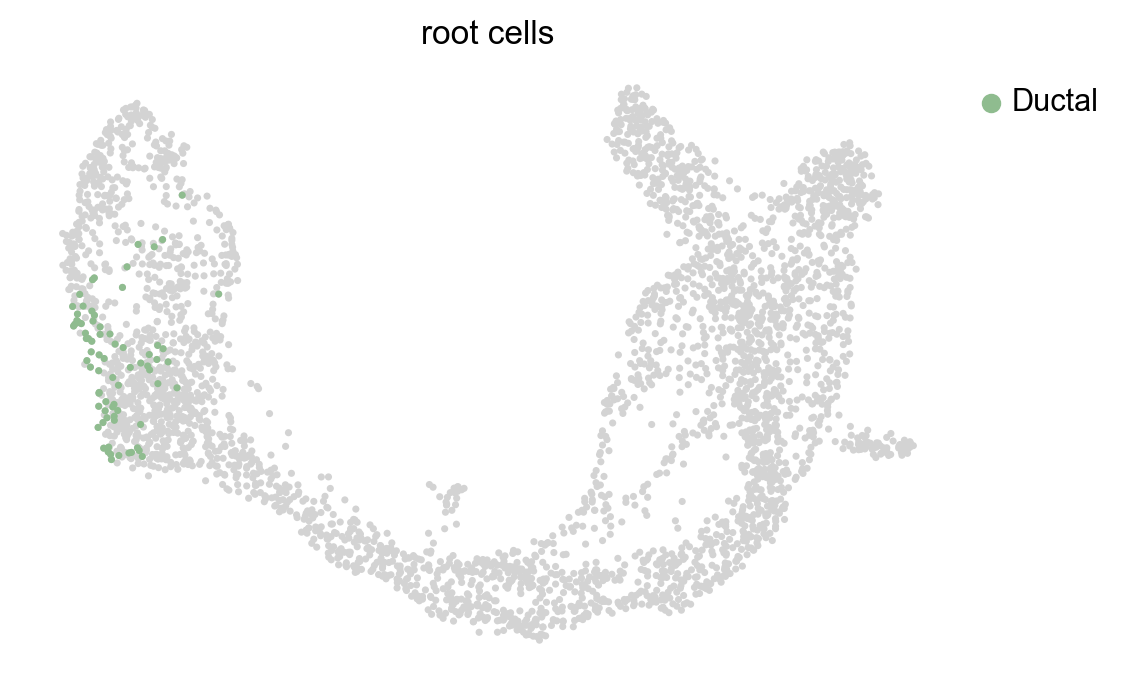

In [23]:
mc_bwd.compute_approx_rcs(cluster_key='clusters')
scv.pl.scatter(adata, color='root_cells')

Note that also when using the low-level mode of interacting with cellrank, results are still written to your AnnData object, e.g. the final cells are in `adata.obs`:

In [24]:
adata.obs['final_cells']

index
AAACCTGAGAGGGATA        NaN
AAACCTGAGCCTTGAT        NaN
AAACCTGAGGCAATTA        NaN
AAACCTGCATCATCCC        NaN
AAACCTGGTAAGTGGC        NaN
                     ...   
TTTGTCAAGTGACATA        NaN
TTTGTCAAGTGTGGCA        NaN
TTTGTCAGTTGTTTGG        NaN
TTTGTCATCGAATGCT        NaN
TTTGTCATCTGTTTGT    Epsilon
Name: final_cells, Length: 3696, dtype: category
Categories (4, object): [Epsilon, Beta, Alpha, Ductal]

That means for downstream analysis, you can just use your adata object, everything has been written!